In [44]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import rand
from scipy import signal
from sklearn.cross_decomposition import CCA

channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
    , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
    , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
frequencies_main = ['4', '5', '5.5', '6', '7', '7.4']
occ_channels = ['O1', 'O2', 'Oz', 'P3', 'P4', 'Pz', 'P7', 'P8']
frequencies = ['8.18_sin_h1', '8.18_cos_h1', '8.18_sin_h2', '8.18_cos_h2', '8.18_sin_h3', '8.18_cos_h3',
               '9_sin_h1', '9_cos_h1', '9_sin_h2', '9_cos_h2', '9_sin_h3', '9_cos_h3',
               '10_sin_h1', '10_cos_h1', '10_sin_h2', '10_cos_h2', '10_sin_h3', '10_cos_h3',
               '11.25_sin_h1', '11.25_cos_h1', '11.25_sin_h2', '11.25_cos_h2', '11.25_sin_h3', '11.25_cos_h3',
               '12.85_sin_h1', '12.85_cos_h1', '12.85_sin_h2', '12.85_cos_h2', '12.85_sin_h3', '12.85_cos_h3',
               '15_sin_h1', '15_cos_h1', '15_sin_h2', '15_cos_h2', '15_sin_h3', '15_cos_h3'
               ]



In [45]:
def perform_cca(fragment, n_components):
    X = fragment[:][occ_channels]
    freqs = []
    t = 0
    for i in range(0, len(frequencies), 6):
        t = t + 1
        Y = fragment[:][frequencies[i:6 * t]]
        ca = CCA(n_components=2)
        ca.fit(X, Y)
        X_c, Y_c = ca.transform(X, Y)
        freqs.append(np.corrcoef(X_c[:, 0], Y_c[:, 0])[0][1])
    return freqs

def perform_cca_2(fragment):
    n_components = 2
    X = fragment[:][occ_channels]
    freqs = []
    t = 0
    for i in range(0, len(frequencies), 6):
        t = t + 1
        Y = fragment[:][frequencies[i:6 * t]]
        ca = CCA(n_components=n_components)
        ca.fit(X, Y)
        X_c, Y_c = ca.transform(X, Y)
        p1 = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0][1]
        p2 = np.corrcoef(X_c[:, 1], Y_c[:, 1])[0][1]
        freqs.append(np.sqrt(p1**2+p2**2))
        if False:
            plt.scatter(X_c[:, 0], Y_c[:, 0], label='EEG Channels', alpha=0.7)
            plt.scatter(X_c[:, 1], Y_c[:, 1], label='Sine curves', alpha=0.7)
            plt.xlabel('X Transformed')
            plt.ylabel('Y Transformed')
            plt.title('CCA Transformed Canonical Variates')
            plt.legend()
            plt.show()
    return freqs

def add_padding(data, lenght=100):
    return padding(data, lenght)

def remove_padding(data, length=100):
    return data[length:-length]

def padding(data, pad_length = 100):
    return np.pad(data, (pad_length, pad_length), mode="reflect")

def get_freqs(N):
    # fs = [8.18, 9, 10, 11.25, 12.86, 15]
    fs = [4, 5, 5.5, 6, 7, 7.4]
    t = N / 250
    return_freqs = []
    for fk in fs:
        for i in range(1, 4):
            return_freqs.append(np.sin(2 * np.pi * i * (t * fk)).tolist())
            return_freqs.append(np.cos(2 * np.pi * i * (t * fk)).tolist())

    df = pd.DataFrame(return_freqs)
    df = df.T
    df.columns = frequencies
    return df

In [46]:

fs = 250  # Frequency
duration = 5  # Signal duration
t = np.arange(0, duration, 1/fs)  # Time
N = np.arange(0, duration*fs, 1)
base_frequency = 7  # Target frequency of signal
noise_amplitude = 0.5


df_freqs = pd.DataFrame(columns=frequencies_main)

for i in range(0,251,25):
    freqs = []
    offset = 0
    eeg_signal = np.sin(2 * np.pi * base_frequency * t + offset) + noise_amplitude * np.random.randn(len(t))
    df = pd.DataFrame([eeg_signal, eeg_signal]).T
    df.columns = ['EEG', 'EEG2']
    frs = get_freqs(N)
    n_components = 2
    #print(df.shape)
    #print(frs.shape)
    X = df[:][['EEG', 'EEG2']]
    h = 0

    # CCA to check the correlation, to make sure the CCA works. The noise can be changed, and the signal can be phase shifted
    # To test for sensitivity
    for y in range(0, len(frequencies), 6):
        h = h + 1
        Y = frs[:][frequencies[y:6 * h]]
        ca = CCA(n_components=n_components)
        ca.fit(X, Y)
        X_c, Y_c = ca.transform(X, Y)
        p1 = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0][1]
        freqs.append(p1)
    df_freqs.loc[f'Shifted {i} Samples'] = (freqs)
display(df_freqs)

,4,5,5.5,6,7,7.4
Shifted 0 Samples,0.028970,0.050569,0.081306,0.040979,0.815358,0.062899
Shifted 25 Samples,0.046400,0.041070,0.078950,0.053404,0.820784,0.037638
Shifted 50 Samples,0.033854,0.030475,0.046018,0.032647,0.819218,0.049105
Shifted 75 Samples,0.032283,0.034244,0.060731,0.052811,0.823943,0.035995
Shifted 100 Samples,0.050370,0.019015,0.037245,0.032400,0.813389,0.024258
Shifted 125 Samples,0.042381,0.017337,0.060956,0.028234,0.822501,0.039506
Shifted 150 Samples,0.045314,0.043391,0.062544,0.030049,0.817879,0.033560
Shifted 175 Samples,0.068656,0.037730,0.045078,0.054970,0.818331,0.020665
Shifted 200 Samples,0.033071,0.021761,0.050724,0.032971,0.820932,0.037958
Shifted 225 Samples,0.025745,0.039050,0.042157,0.032941,0.810986,0.027128


Text(0.5, 1.0, 'Signal with Two Sinusoids of Different Frequencies and Phase Shifts')

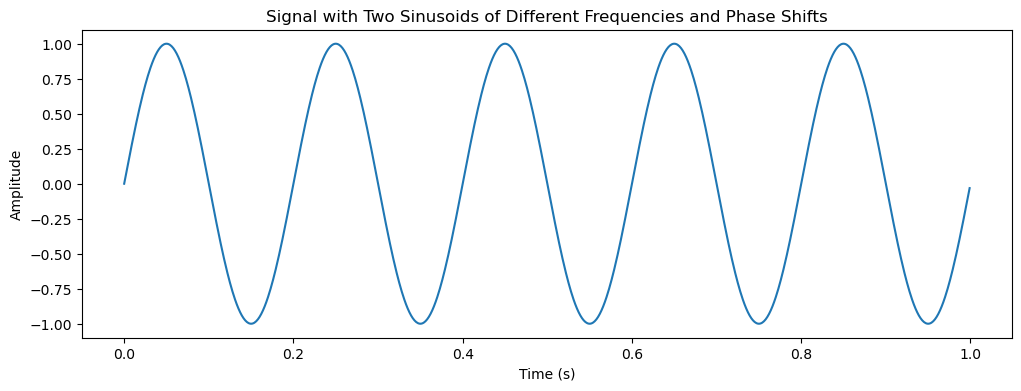

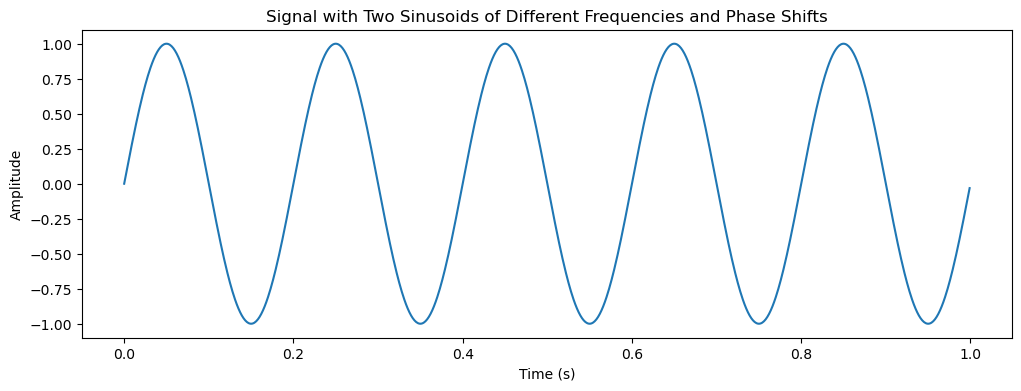

In [47]:
import numpy as np
import matplotlib.pyplot as plt

fs = 1000  # Sampling frequency (Hz)
duration = 1  # Duration of the signal (seconds)

t = np.arange(0, duration, 1/fs)  # Time vector

# Define the sinusoidal components
freq1 = 5  # Frequency of the first sinusoid (Hz)
phase_shift1 = 0  # Phase shift of the first sinusoid (radians)

freq2 = 5  # Frequency of the second sinusoid (Hz)
phase_shift2 = 0# Phase shift of the second sinusoid (radians)

# Create the two sinusoidal components
sin1 = np.sin(2 * np.pi * freq1 * t + phase_shift1)
sin2 = np.sin(2 * np.pi * freq1 * t + phase_shift2)


signal = sin1

# Check both plots to see any phase distortion
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal with Two Sinusoids of Different Frequencies and Phase Shifts")

plt.figure(figsize=(12, 4))
plt.plot(t, sin2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal with Two Sinusoids of Different Frequencies and Phase Shifts")
